In [1]:
% matplotlib inline

from __future__ import division
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib as mlab
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.tsa.tsatools import detrend
from scipy.spatial.distance import pdist, squareform
from scipy import signal
import time as tm
import gsw as sw
from scipy.optimize import curve_fit
from scipy.stats import chi2

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

In [2]:
def convert_KM(sds):
    lon_tmp = sds[(sds['cruise']=='KiloMoana_1')]['lon']
    lon_tmp = lon_tmp//100 + (lon_tmp - lon_tmp//100*100)/60
    lat_tmp = sds[(sds['cruise']=='KiloMoana_1')]['lat']
    lat_tmp = lat_tmp//100 + (lat_tmp - lat_tmp//100*100)/60
    
    sds.loc[sds['cruise']=='KiloMoana_1','lon'] = -lon_tmp
    sds.loc[sds['cruise']=='KiloMoana_1','lat'] = lat_tmp
    
    lon_tmp2 = sds[(sds['cruise']=='SCOPE_2')]['lon']
    lon_tmp2 = lon_tmp2//100 + (lon_tmp2 - lon_tmp2//100*100)/60
    lat_tmp2 = sds[(sds['cruise']=='SCOPE_2')]['lat']
    lat_tmp2 = lat_tmp2//100 + (lat_tmp2 - lat_tmp2//100*100)/60
    
    sds.loc[sds['cruise']=='SCOPE_2','lon'] = -lon_tmp2
    sds.loc[sds['cruise']=='SCOPE_2','lat'] = lat_tmp2
    
    return sds

def checklon(data):
    cxx = (data['lon']).values # longitude

    # convert all longitude to longitude east
    cxx[cxx<0]= 360+cxx[cxx<0];
    data['lon_e'] = cxx
    cxbew = cxx
    cxbew[cxbew>180] = cxbew[cxbew>180]-360   
    data['lon'] = cxbew
    return data

def distance(data):
    cruise = pd.unique(data['cruise'])
    print cruise
    distances = pd.DataFrame()    
    for c in cruise:
        temp = pd.DataFrame()
        temp = data.loc[(data['cruise']==c), ['cruise','file_time','lon','lat']]
        
        # calculate distance in km between points
        temp['dx'] = np.insert(sw.distance(temp['lon'].values, temp['lat'].values, 0),0,0)/1000
        temp['x'] = np.cumsum(temp['dx'])
        
        if c == cruise[0]:
            distances = distances.append(temp)
        else:
            distances = pd.concat([distances, temp], axis=0)
        del temp
    data = pd.merge(left = data, right = distances, how='left', left_on=['cruise','file_time','lat','lon'], right_on=['cruise','file_time','lat','lon'])
    #return distances

    return data  

def tracks(data):
    seg = []
    start = 0
    n = 1
    for i in range(len(data)):
        if ((data['dx'][i] > 20) | (data['dx'][i] < 0.01)):
            seg.append([data['cruise'][i], start, i-1, sum(data['dx'][start:i-1])])# - data['x'][start])])
                                                         
            n += 1
            start = i+1
    
    segments = pd.DataFrame(seg, columns = ['cruise', 'start', 'end', 'length']) 
    segments = segments.loc[(segments['length'] >= 200)]
    segments = segments.loc[(segments['end'] > 0)]
    segments['number'] = range(1, len(segments)+1)
    segments = segments.set_index(['number'])
    return segments
        
        
def fft_data(detdata, var, cruise, segnumber):
    # initialize the dataframe for the scales
    scales = pd.DataFrame()
    seg_fft = pd.DataFrame()
   
    # set the length of the segments to look at
    ll = len(detdata) # length of decorrelation segment
    
    
    scales['lat'] = (detdata['lat'].values)[ll/2]
    scales['lon'] = (detdata['lon'].values)[ll/2]
    scales['depth_mid'] = (detdata['depth'].values)[ll/2]
    scales['dcoast_mean'] = np.nanmean(detdata['dcoast'].values)
    scales['dcoast_mid'] = (detdata['dcoast'].values)[ll/2]
    scales['depth_mean'] = np.nanmean(detdata['depth'].values)
    scales['cruise'] = cruise
    scales['segment #'] = segnumber
    print segnumber, ll, cruise, (detdata['lat'].values)[ll/2], (detdata['lon'].values)[ll/2], np.mean(detdata['dom_group'].values)
    
    
    freq = np.fft.fftfreq(ll, 1.0)
    seg_fft['wavenumber'] = freq
        
    for v in var:

        tmp = detdata[v]

        # initialize array for the results, needs to b 3 cols, length t
        data = tmp
        yf = np.fft.fft(data*np.hanning(len(data)))
                                         
        # append to the scales dataframe
        v2 = '%s_%d' % (v, segnumber)
       
        seg_fft[v2] = yf**2
        del yf
            
    return scales, seg_fft
        

def interpdata(track, aa, bb, var):
    # we went to create a new dataframe which has the interpolated data for each track for all variables, 
    # and a position.
    intdata = pd.DataFrame()
    # set the interpolation distance 
    n = 1 # 1km 
    begin = np.floor(track['x'][:1])
    intdata['x'] = np.arange(aa, bb, n)
 
    for v in var:
        intdata[v] = np.interp(intdata['x'].values,track['x'].values,track[v].values)
          
    return intdata

def despike(tmp, var):
    # use 5 point median to despike data
    despiked = pd.DataFrame()
    n= 5
    nn = len(tmp)

    for v in var:
        vv = tmp[v].values
        tmp1 = np.zeros(nn-4)
        for m in range(nn-4):
            tmp1[m] = np.median(vv[[m, m+1, m+3, m+4]])
        despiked[v] = tmp1

        del tmp1
        
    despiked['x'] = tmp['x'][2:len(despiked)-2]
    despiked['lon'] = tmp['lon'][2:len(despiked)-2]
    despiked['lat'] = tmp['lat'][2:len(despiked)-2]
    despiked['depth'] = tmp['depth'][2:len(despiked)-2]
    despiked['dcoast'] = tmp['dcoast'][2:len(despiked)-2]
#    despiked['dom_group'] = tmp['dom_group'][2:len(despiked)-2]
    return despiked
        
def detrenddata(track, var2):
    # take the interpolated data and remove the large scale trend, e.g. apply a high pass filter.
    detdata = pd.DataFrame()
    detdata['x'] = track['x']
    detdata['lon'] = track['lon']
    detdata['lat'] = track['lat']
    detdata['depth'] = track['depth']
    detdata['dcoast'] = track['dcoast']
#    detdata['dom_group'] = track['dom_group']
    

    # First, design the Butterworth filter
    N  = 3    # Filter order
    cutoff = 250. # length scale for cutoff
    Wn = 1/cutoff # Cutoff wavelength, normalised to n
    B, A = signal.butter(N, Wn, 'low', output='ba')
    
    # Second, apply the filter to each of the variables
    
    for v in var2:
        detdata[v] = track[v] - signal.filtfilt(B,A, track[v])
    return detdata
    

def fftbin(fft, bins, bin_mid):
    
    y = 1/(np.abs(fft['wavenumber'].values))
    
    binned = pd.DataFrame()
    bin_count = np.zeros(len(bins)-1)
    binned['k_mid'] = bin_mid
    
    var = fft.columns
    for v in var:
        
        z = np.abs(fft[v].values) 
        
        digitized = np.digitize(y, bins)
        bin_count = [np.shape(z[digitized == i])[0] for i in range(1, len(bins))]

        bin_means = [np.nanmean(z[digitized == i]) for i in range(1, len(bins))]
        bin_std = [np.nanstd(z[digitized == i]) for i in range(1, len(bins))]
        
        binned[v] = bin_means
        
        v1 = '%s_sd' % v
        binned[v1] = bin_std

    return binned   

def most_abundant(row):
    if row['pico'] > row['synecho'] and row['pico'] > row['picoeuk']: 
        return 1
    if row['synecho'] > row['pico'] and row['synecho'] > row['picoeuk']: 
        return 2
    if row['picoeuk'] > row['synecho'] and row['picoeuk'] > row['pico']: 
        return 3
    
def csdbin(cxy, f, bins, bin_mid):
    
    y = 1/(np.abs(f))
    
    binned = pd.DataFrame()
    bin_count = np.zeros(len(bins)-1)

    z = np.abs(cxy) 

    digitized = np.digitize(y, bins)
    bin_count = [np.shape(z[digitized == i])[0] for i in range(1, len(bins))]

    bin_means = [np.nanmean(z[digitized == i]) for i in range(1, len(bins))]
    bin_std = [np.nanstd(z[digitized == i]) for i in range(1, len(bins))]/np.sqrt(bin_count)

    return bin_means, bin_std  

In [3]:
# import mega dataset
filePath = '/Users/archie/Google Drive/seaflow_data/KM1_abun_sds_opp.csv'
data = pd.read_csv(filePath, sep=',')


filePath = r'/Users/archie/Google Drive/seaflow_data/sds_depth.csv'
depth = pd.read_csv(filePath)

filePath = r'/Users/archie/Google Drive/seaflow_data/sds_dist2coast.csv'
dcoast = pd.read_csv(filePath)

filePath = '/Users/archie/Google Drive/seaflow_data/KM1_chl.csv'
chl = pd.read_csv(filePath, sep=',')
print chl.columns

Index([u'cruise', u'file_time', u'chl'], dtype='object')


In [4]:
# add density 
data['density'] = sw.rho(data['salinity'].values,data['ocean_tmp'].values,0)
data = checklon(data)

# only keep KM1304 data
data = data[(data['cruise']=='KiloMoana_1')]
               
# sort the dataframe so that it is in date/time order
data = pd.merge(data, depth, on=['cruise','file_time'], how='inner')
data = pd.merge(data, dcoast, on=['cruise','file_time'], how='inner')
data = pd.merge(data, chl, on=['cruise','file_time'], how='inner')
data = data.sort_values(by = ['cruise', 'file_time'],ascending=[1, 1])
data = data.reset_index(drop=True)

# now we have a dataframe with the total alongtrack distance for each cruise, 
# and the distance between points for each file.

clean = data[['cruise', 'file_time', 'lon', 'lon_e', 'lat', 'depth', 'dcoast', 'salinity', 'ocean_tmp', 'density', 'pico', 'synecho', 'picoeuk', 'chl']]
clean['tot_chl'] = data['tot_chl']#/(data['file_duration']*data['opp.evt']*data['flow_rate'])
clean = clean.sort_values(by = ['cruise', 'file_time'],ascending=[1, 1])
clean['dom_group']= clean.apply(most_abundant, axis =1)
clean = distance(clean)


['KiloMoana_1']


/Users/archie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# split the data into continuous segments at least 200 km long with no gaps bigger than 20 km.
segments = tracks(clean)

# now do the length scale analysis
# interpolate the data, detrend it using the low pass filter, then find the decorrelation scales
# loop over each segment
var = ['lat', 'lon', 'tot_chl', 'chl', 'ocean_tmp', 'salinity', 'density', 'synecho', 'pico', 'picoeuk','depth', 'dcoast']
var2 = ['chl', 'tot_chl', 'ocean_tmp', 'salinity', 'density', 'synecho', 'pico', 'picoeuk']



1


/Users/archie/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


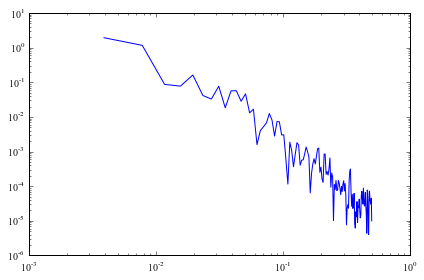

2


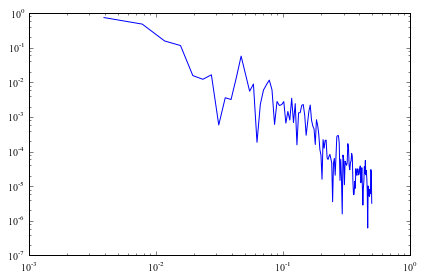

3


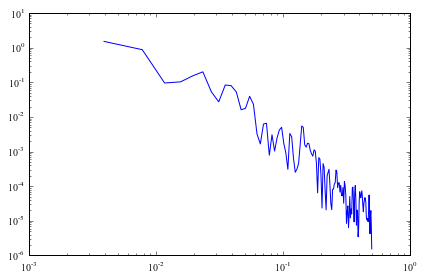

4


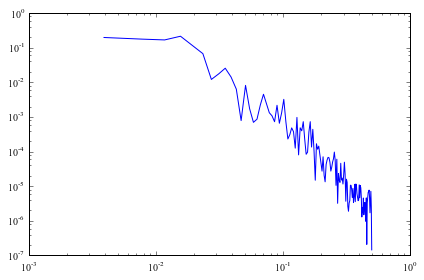

5


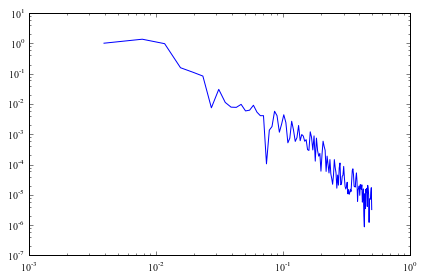

6


/Users/archie/anaconda/lib/python2.7/site-packages/scipy/signal/spectral.py:772: UserWarning: nperseg = 256, is greater than input length = 243, using nperseg = 243
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))


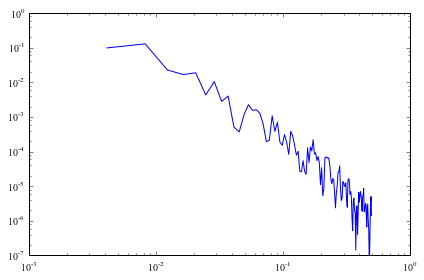

7


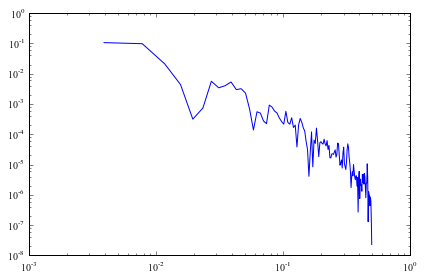

8


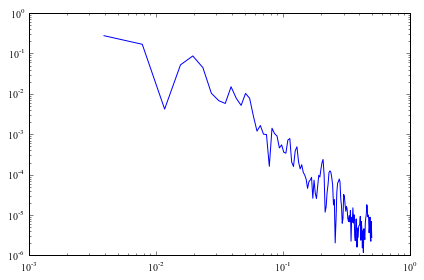

9


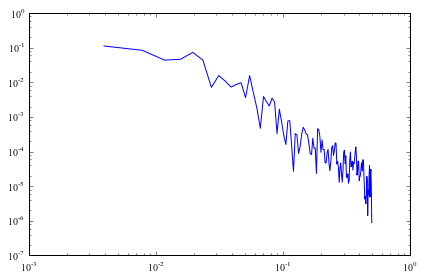

In [6]:
for i in range(1, len(segments)+1):
    a = segments['start'][i]
    b = segments['end'][i]

    tmp = clean[a:b]
    segnumber = i
    cruise = segments['cruise'][i]
    aa = clean['x'][a]
    bb = clean['x'][b]
    fs = 1.

    tmp = interpdata(tmp, aa, bb, var)
    # add a step for despiking the data using 5 point median
    seglength = len(tmp)

    # change tmp to tmp4 to analyse the despiked version
    tmp1 = detrenddata(tmp, var2) 
    print i
    csd_var = ['chl','density']
    a = tmp1[csd_var[0]]
    b = tmp1[csd_var[1]]
    
    f, Pxy = signal.csd(a, b, fs, window = 'hanning')
    plt.loglog(f, np.abs(Pxy))
    plt.show()
    
    del tmp, tmp1

1


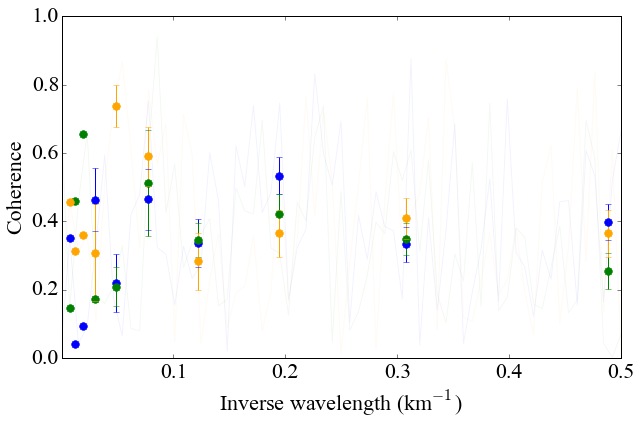

2


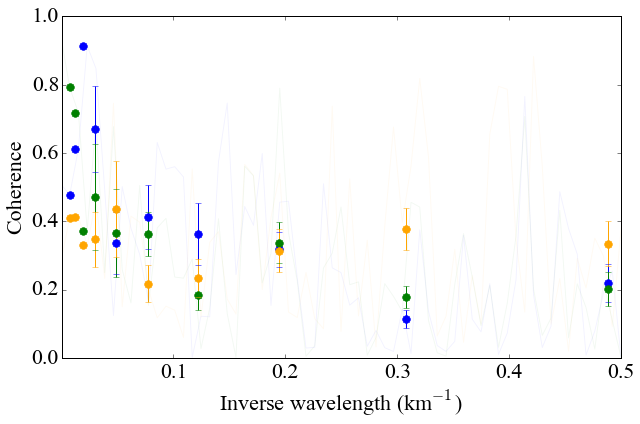

3


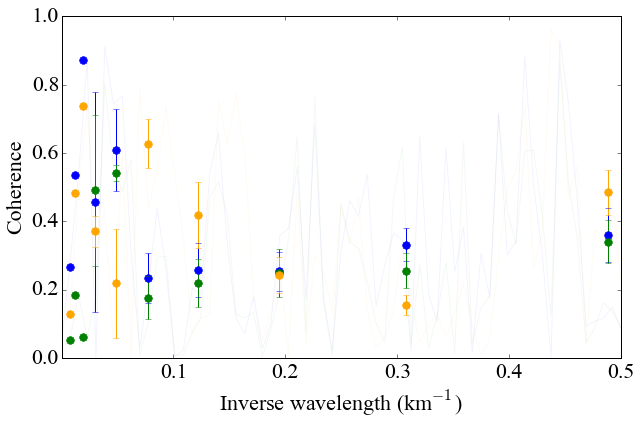

4


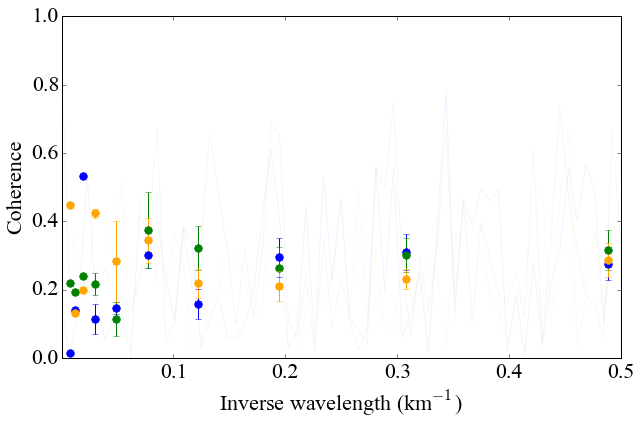

5


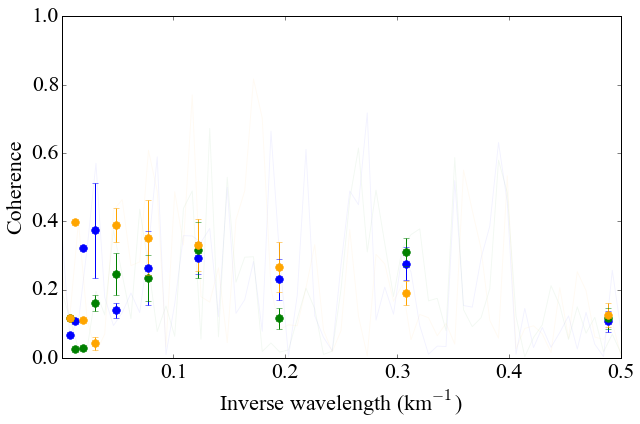

6


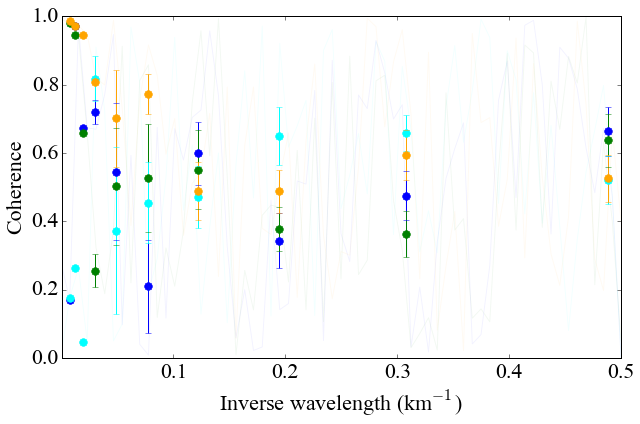

7


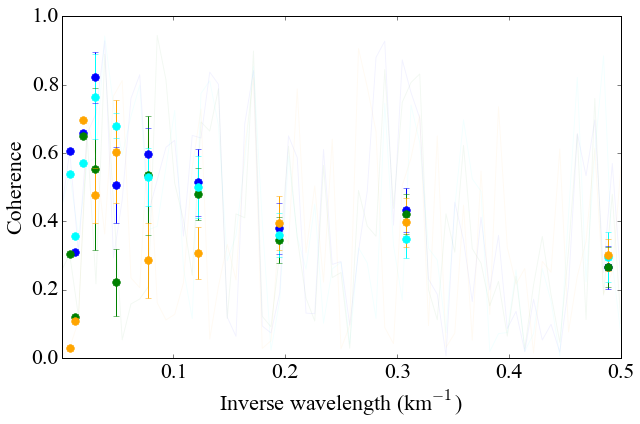

8


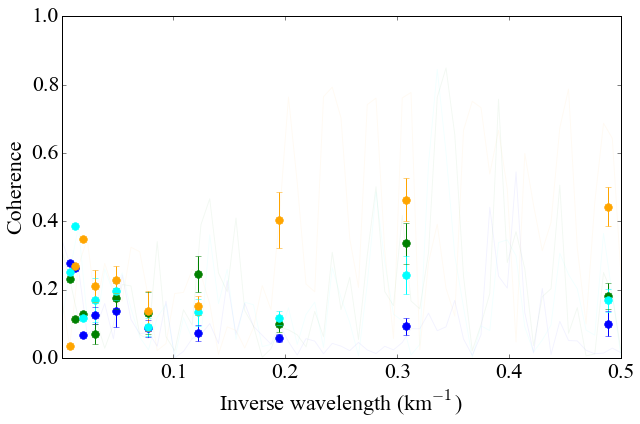

9


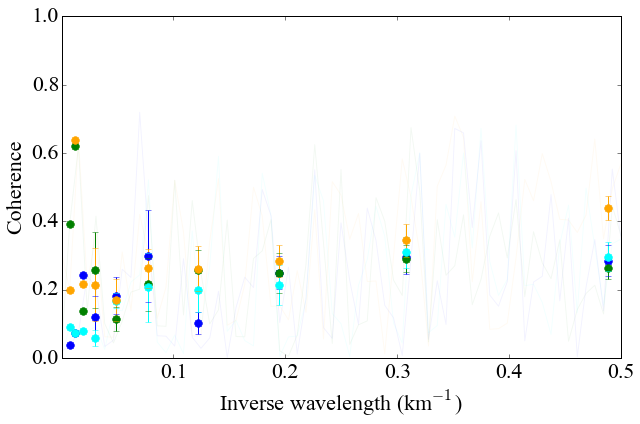

In [11]:
for i in range(1, len(segments)+1):
    a = segments['start'][i]
    b = segments['end'][i]

    tmp = clean[a:b]
    segnumber = i
    cruise = segments['cruise'][i]
    aa = clean['x'][a]
    bb = clean['x'][b]
    fs = 1.

    tmp = interpdata(tmp, aa, bb, var)
    # add a step for despiking the data using 5 point median
    seglength = len(tmp)

    # change tmp to tmp4 to analyse the despiked version
    tmp1 = detrenddata(tmp, var2) 
    print i
    csd_var = ['ocean_tmp', 'synecho', 'picoeuk', 'pico', 'chl']
    a = tmp1[csd_var[0]]
    b = tmp1[csd_var[1]]
    c = tmp1[csd_var[2]]
    d = tmp1[csd_var[3]]
    e = tmp1[csd_var[4]]
    
    f, Cxy = signal.coherence(a, b, fs, nperseg = 128, detrend = False, window='hanning')
    fp, Pxy = signal.csd(a, b, fs, window = 'hanning')
    f, Cxy2 = signal.coherence(a, c, fs, nperseg = 128, detrend = False, window='hanning')
    fp, Pxy2 = signal.csd(a, c, fs, window = 'hanning')
    f, Cxy3 = signal.coherence(a, d, fs, nperseg = 128, detrend = False, window='hanning')
    fp, Pxy3 = signal.csd(a, d, fs, window = 'hanning')
    f, Cxy4 = signal.coherence(a, e, fs, nperseg = 128, detrend = False, window='hanning')
    fp, Pxy4 = signal.csd(a, e, fs, window = 'hanning')

    
    k_bins = 10 ** (0.2 * np.arange(15))
    k_bin_mid = k_bins[:(len(k_bins)-1)] + np.diff(k_bins)/2

    binned, bin_std = csdbin(Cxy, f, k_bins, k_bin_mid)
    binned2, bin_std2 = csdbin(Cxy2, f, k_bins, k_bin_mid)
    binned3, bin_std3 = csdbin(Cxy3, f, k_bins, k_bin_mid)
    binned4, bin_std4 = csdbin(Cxy4, f, k_bins, k_bin_mid)
    
    plt.figure(figsize=(9, 6), dpi = 600)
    plt.errorbar(1/k_bin_mid, binned, yerr = bin_std, fmt='.', color='b', markersize=15)
    plt.plot(f, Cxy, 'b', alpha = 0.05)
    
    plt.errorbar(1/k_bin_mid, binned2, yerr = bin_std2, fmt='.', color='g', markersize=15)
    plt.plot(f, Cxy2, 'g', alpha = 0.05)
    
    plt.errorbar(1/k_bin_mid, binned3, yerr = bin_std3, fmt='.', color='cyan', markersize=15)
    plt.plot(f, Cxy3, 'cyan', alpha = 0.05)
    
    plt.errorbar(1/k_bin_mid, binned4, yerr = bin_std4, fmt='.', color='orange', markersize=15)
    plt.plot(f, Cxy4, 'orange', alpha = 0.05)
    
    #plt.xscale('log')
    plt.axis([0.001, 0.5, 0, 1])
    
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.tick_params(axis='both', which='minor', labelsize=22)
    plt.xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 22)
    plt.ylabel('Coherence', fontsize = 22)
    plt.show()
    
    del tmp, tmp1
